# Train models

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Lambda
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, KFold

import rs_models
from matplotlib import pyplot as plt
import math
from tqdm import tqdm

import implicit
from implicit.evaluation import AUC_at_k, precision_at_k, train_test_split
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix, csr_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

pd.options.display.max_columns = 1000
import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [ ]:
def load_dataset(name : str):
    if dataset == 'mdf':
        #df = pd.read_csv('Datasets/MDF_social/MDF_with_social_features.csv')
        df = pd.read_csv('Datasets/MDF_social/social_datasets/MDF_user2.csv')
        df_mf = pd.read_csv('Datasets/MDF_matrix_factorization.csv')
        df = df.drop(columns='time')
        df = df.drop_duplicates()
        # df = df[df.item != 2]
        # df = df.drop(['place_type_food_and_drink', 'place_type_health', 'place_type_home', 'place_type_lodging','place_type_outdoors', 'place_type_point_of_interest_establishment','place_type_public_transport_station', 'place_type_school','place_type_service', 'place_type_store', 'place_type_workplace'], axis = 1)
        df = df.reset_index(drop=True)
        context_labels = list(df.columns[3:66])
        item_labels = list(df.columns[66:92])
        user_labels = list(df.columns[92:106])
        social_labels = list(df.columns[106:])

    elif dataset == 'frappe':
        df = pd.read_csv('Datasets/frappe dataset/frappe_final.csv')
        df_mf = pd.read_csv('Datasets/frappe dataset/frappe_matrix_factorization.csv')
        context_labels = list(df.columns[3:27])
        item_labels = list(df.columns[27:54])
        user_labels = list(df.columns[54:])
        social_labels = []
    return df, df_mf, user_labels, item_labels, context_labels, social_labels

In [ ]:
dataset = 'mdf'
df, df_mf, user_labels, item_labels, context_labels, social_labels = load_dataset(dataset)

n_users = df.user.nunique()
n_items = df.item.nunique()
n_contexts = len(context_labels)

print(f"rating with value 1: {df[df.rating == 1]['rating'].count() * 100 / len(df)} %")
print(f"users: {n_users} \t items: {n_items} \t rating: {len(df)}")
print(f"user_features: {len(user_labels)} \t items_features: {len(item_labels)} \t social_features: {len(social_labels)} \t contexts_features: {n_contexts} \t ")

In [ ]:
n_splits = 10
models_eval_metrics = {}

## ALS matrix factorization

In [ ]:
ratings = coo_matrix((df_mf['rating'].astype(np.float32),
                     (df_mf['item'],
                      df_mf['user']))).tocsr()

auc = 0
train, test = train_test_split(ratings, train_percentage=0.80)
for split in range(n_splits):
    model = AlternatingLeastSquares(factors=256, regularization=8, iterations=10, calculate_training_loss=True)
    model.fit(train, show_progress=False)
    auc = auc + rs_models.mf_AUC(model, train, test)
auc = auc / n_splits
print(f"ALS \t AUC: {auc}")
models_eval_metrics['ALS'] = [0, auc, 0, 0]

## NeuMF

In [ ]:
param = {
    'n_users': n_users,
    'n_items': n_items,
    'n_contexts': n_contexts,
    'learn_rate': 0.001,
    'batch_size': 2048,
    'epochs': 5
}   


std_dev, accuracy, auc, precision, recall = rs_models.kfold_train(rs_models.NeuMF, param, df, n_splits=n_splits)
models_eval_metrics['NeuMF'] = [accuracy, auc, precision, recall]
print(f"NeuMF \t accuracy: {accuracy*100}% \t AUC: {auc} \t precision: {precision} \t recall: {recall}")

## ECAM NeuMF

In [ ]:
param = {
    'n_users': n_users,
    'n_items': n_items,
    'n_contexts': n_contexts,
    'learn_rate': 0.001,
    'batch_size': 2048,
    'epochs': 5
}  

std_dev, accuracy, auc, precision, recall = rs_models.kfold_train(rs_models.ECAM_NeuMF, param, df, context_labels=context_labels, n_splits=n_splits)
models_eval_metrics['ECAM NeuMF'] = [accuracy, auc, precision, recall]
print(f"ECAM NeuMF \t accuracy: {accuracy*100}% \t AUC: {auc} \t precision: {precision} \t recall: {recall}")

## Classifier

In [ ]:
ffnet = KerasClassifier(build_fn=rs_models.mobile_model, neurons=100, layers=3, learn_rate=0.01, epochs=20, batch_size=128, verbose=False)
x = df[item_labels + user_labels]
y = df['rating']

scores = cross_validate(ffnet, x, y, cv=KFold(shuffle=True, n_splits=n_splits, random_state=42), scoring=['accuracy', 'roc_auc', 'precision', 'recall'])

accuracy = np.average(scores['test_accuracy'])
auc = np.average(scores['test_roc_auc'])
precision = np.average(scores['test_precision'])
recall = np.average(scores['test_recall'])
models_eval_metrics['Classifier'] = [accuracy, auc, precision, recall]

print(f"Classifier \t accuracy: {accuracy*100}% \t AUC: {auc} \t precision: {precision} \t recall: {recall}")

## Plot Results

In [ ]:
n_models = len(models_eval_metrics) # number of different models
models_name = [x[0] for x in models_eval_metrics.items()] 
accuracy = [x[0] for x in models_eval_metrics.values()]
auc = [x[1] for x in models_eval_metrics.values()]
precision = [x[2] for x in models_eval_metrics.values()]
recall = [x[3] for x in models_eval_metrics.values()]

index = np.arange(n_models)
bar_width = 0.50
plt.figure(figsize=(10,6))

plt.bar(index, auc, bar_width, color='tab:orange', label='AUC')

for i, value in enumerate(auc): # add metric value at the top of the bar
    plt.text(i-bar_width/3, value + 0.01, str(round(value, 4))) # parameters are x position, y position, value
    
plt.style.use("fivethirtyeight")
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Prediction results')
plt.xticks(index, models_name) # labels position
plt.legend(bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.savefig('prediction_results.png')
plt.show()

## Train Classifier only on some features

In [57]:
results = {'mdf':[], 'frappe':[]}

# build a dictionary that contains AUC results of the classifier trained at first on user feature and first on user features,
# and then gradually adding item, social and context features
for dataset in results.keys():
    df, df_mf, user_labels, item_labels, context_labels, social_labels = load_dataset(dataset)
    y = df['rating']
    train_labels = [item_labels+user_labels, item_labels+user_labels+social_labels, item_labels+user_labels+social_labels+context_labels]

    for x_labels in train_labels:
        x = df[x_labels]
        ffnet = KerasClassifier(build_fn=rs_models.mobile_model, neurons=100, layers=3, learn_rate=0.01, epochs=20, batch_size=128, verbose=False)
        scores = cross_validate(ffnet, x, y, cv=KFold(shuffle=True, n_splits=2, random_state=42), scoring=['accuracy', 'roc_auc', 'precision', 'recall'])
        auc = np.average(scores['test_roc_auc'])
        print(dataset, auc)
        results[dataset].append(auc)

mdf 0.7103038393387685
mdf 0.8595381341324908
mdf 0.9793030650923131
frappe 0.7505836667733624
frappe 0.7497308211786693
frappe 0.7965379072585765


In [58]:
for dataset in results.keys():
    results[dataset] = [results[dataset][0]] + [x-y for x, y in zip(results[dataset][1:], results[dataset])]    
print(results)

{'mdf': [0.7103038393387685, 0.1492342947937223, 0.11976493095982232], 'frappe': [0.7505836667733624, -0.000852845594693119, 0.046807086079907245]}


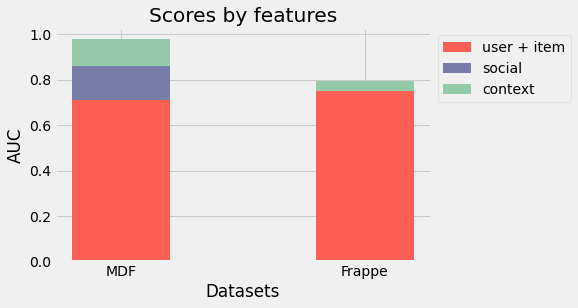

In [62]:
# create data
x = ['MDF', 'Frappe']
y1 = np.array([x[0] for x in results.values()]) 
y2 = np.array([x[1] for x in results.values()]) 
y3 = np.array([x[2] for x in results.values()]) 
  
# plot bars in stack manner
bar_width = 0.40
plt.bar(x, y1, bar_width, color='#FE5F55')
plt.bar(x, y2, bar_width, bottom=y1, color='#777DA7')
plt.bar(x, y3, bar_width, bottom=y1+y2, color='#94C9A9')

plt.xlabel("Datasets")
plt.ylabel("AUC")
#plt.legend(["user", "user+item", "user+item+social", "user+item+social+context"])
plt.title("Scores by features")
plt.style.use("fivethirtyeight")
plt.legend(["user + item", "social", "context"], bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()